#### Import relevant modules

In [2]:
import pandas as pd
import numpy as np
import os,math,timeit,time,json
import matplotlib.pyplot as plt
import seaborn as sns
import dask.dataframe as dd

from sklearn import preprocessing
from sklearn.model_selection import train_test_split,GridSearchCV,StratifiedKFold,RandomizedSearchCV
from sklearn import metrics
from sklearn.preprocessing import MinMaxScaler,StandardScaler
from imblearn.over_sampling import SMOTE
from sklearn.feature_selection import SelectFromModel

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier,ExtraTreesClassifier,AdaBoostClassifier
from sklearn.linear_model import LogisticRegression,SGDClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.naive_bayes import GaussianNB,MultinomialNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.ensemble import GradientBoostingClassifier
from xgboost.sklearn import XGBClassifier

# neural network
from keras import Sequential,models,regularizers,layers
from keras.models import load_model
from keras.layers import Dense,Dropout
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint

import feature_selection_ga as FSGA

Using TensorFlow backend.


#### Define required help functions

In [3]:
def parse_json_file(filename):
    '''
       Convert a large json file into a Pandas Dataframe
    '''
    with open(filename,'rb') as json_file:
        data = json_file.readlines()
        # It converts all strings in list to actual json objects. This is faster than pandas read_json
        data = list(map(json.loads, data)) 
    return pd.DataFrame(data)

In [4]:
def list_to_string(colnames,dfname):
    '''
       Convert the list values in colnames into strings
    '''
    for col in colnames:
        dfname[col].fillna(value='',inplace=True)
        dfname[col]= [','.join(map(str, l)) for l in dfname[col] ]
    return dfname

In [5]:
def dedup_data(df,keylist = []):
    ''' remove full row duplicates from the given dataframe    '''
    if not keylist:
        return df.drop_duplicates(keep='first') 
    else:
        return df.drop_duplicates(subset = keylist,keep='first')

In [6]:
def prep_Data(df):
    '''A generic function to load a given file, display basic analysis and return a pandas dataframe'''     
    
    percent_missing = df.isnull().sum() * 100 / len(df)
    missing_value_df = pd.DataFrame({'column_name': df.columns,'percent_missing': percent_missing})
    missing_value_df.sort_values('percent_missing',ascending =False, inplace=True)
    
    print('\n Basic Metadata \n')
    print(df.info())
    print('\n Missing values information \n')
    print(missing_value_df[missing_value_df.percent_missing>0])
    
    return df 

In [7]:
def imputeNulls(df):
    ''' Find and impute null/missing values based on data type'''
    
    nullcols = df.columns[df.isna().any()].tolist()    
    
    for c in nullcols:
        if df[c].dtype=='object':
            df[c] = df[c].fillna('')
        else:
            df[c] = df[c].fillna(0)
    
    print('\n List of columns with missing values now :',df.columns[df.isna().any()].tolist())
        
    return df

In [8]:
def encode_cols(df,target_col=''):
    '''Encode all categorical columns'''
    #prepare list of all categorical variables in the dataset
    catlist = df.select_dtypes(include='object').columns.tolist() 
    if target_col:
        catlist = [ c for c in catlist if c!=target_col]
        df[target_col] = df[target_col].apply(lambda x:0 if x=='F' else 1)
    
        
    label_encoder = preprocessing.LabelEncoder() 
    df[catlist] = df[catlist].apply(label_encoder.fit_transform)   
      
    
    return df

In [9]:
def scale_cols(df,scaler,excep_list):
    '''Scale continuous variables in data'''    
    
    #prepare list of all continuos variables in the dataset
    contvars = df.select_dtypes(exclude='object').columns.tolist()     
    contvars = [c for c in contvars if c not in excep_list]
    
    df[contvars] = scaler.fit_transform(df[contvars])    
    return df

In [10]:
def class_dist(df,target_col):
    '''Produce a graph of target class distribution for analysis '''
    
    df1 = pd.crosstab(index = df[target_col], columns = "count")
    df1['percent'] = df1/df1.sum() * 100
    
    print('\n Check target class distribution \n')
    print(df1)
    
    # graph of class distribution of the target variable
    df1.plot(kind='barh')
    plt.show()
    return None

In [11]:
def level_chk(df):
    '''Show the numbe rof levels of each feature in dataframe'''
    
    cols = df.select_dtypes(exclude='object').columns.tolist()
    nlevels = [ (c,df[c].nunique()) for c in cols]
    
    print(pd.DataFrame(sorted(nlevels,key = lambda x:x[1]),columns = ['col_name','n_levels']))
    return None 

In [12]:
def reduce_dims(df,target_col):  
        cols_retained = [ c for c in df.columns if c!=target_col]
        model = ExtraTreesClassifier(random_state=42,class_weight='balanced') # for repeatability of results
        # send only 5k rows for quick response
        fsga = FSGA.FeatureSelectionGA(model,df.loc[:8000,cols_retained].values
                                       ,df.loc[:8000,target_col])
        pop = fsga.generate(100)
        new_retained = []
        prev_cols = len(cols_retained)
        
        for ind,val in enumerate(pop):
            if val:
                new_retained.append(cols_retained[ind])
        
        cols_retained = new_retained[:]
        print("\n Columns retained after Genetic Selection Algorithm are: \n",cols_retained)
        print("\n {} columns retained out of {} \n".format(len(cols_retained),prev_cols))
        return df[cols_retained+[target_col]]

In [13]:
def plot_feature_imp(df,target_col):
    '''
    Plot a feautre importance graph for analysis
    '''
    
    clf = ExtraTreesClassifier(n_estimators=10,random_state=42,class_weight='balanced') # for repeatability of results
  
    X = df[[c for c in df.columns if c!=target_col]]
    y = df[target_col]
    clf.fit(X,y)    
    
    pd.Series(clf.feature_importances_, index=df.columns[1:]).plot.bar(color='steelblue', figsize=(12, 18))
    plt.show()
    return clf,X,y

In [14]:
def plot_corr(df):
    # Basic correlogram
    corr=df.corr()
    fig, ax = plt.subplots(figsize=(12,16))
    sns.heatmap(corr,xticklabels=corr.columns.values,yticklabels=corr.columns.values,annot=True,ax=ax)
    plt.show()
    return None

In [15]:
def create_Xy(df,target_col,imbalance = 'N'):
    '''
    Separate the predictors from the target
    '''
    # assign variables and target data
    y = df[target_col]
    X = df.loc[:,df.columns!=target_col]
    model_cols = X.columns # store the columns to be used as predictors
    
    if imbalance == 'Y':
        # use SMOTE-Synthetic Minority Over-sampling Technique to balance out the target classes
        sm = SMOTE(random_state=42)
        X,y = sm.fit_resample(X, y)
    
    
    print('\n No: of predictor variables is: {} and no:of observations for training is: {} \n'.format(X.shape[1],X.shape[0]))
    return X,y,model_cols

In [43]:
def creatNN(inp_cols,inp_rows,activation='relu',kernel_initializer='uniform',alpha=10,droporate=0.5):
    base_model = models.Sequential()
    
    '''
     Nh=Ns/(α∗(Ni+No))

     Ni= number of input neurons(inp_cols)
     No = number of output neurons(1)
     Ns = number of samples in training data set(inp_rows)
     α = an arbitrary scaling factor usually 2-10 (alpha)
     
     OR Nh = 2/3 *(inp_cols+1)
     '''
    
    #Hidden Layer
    #base_model.add(layers.Dense(int(inp_rows/(alpha*(inp_cols+1))), activation=activation, kernel_initializer=kernel_initializer                         
    #                     ,kernel_regularizer=regularizers.l2(0.001),input_dim=inp_cols))
    base_model.add(layers.Dense(int((2/3)*(inp_cols+1)+inp_cols), activation=activation, kernel_initializer=kernel_initializer                         
                         ,kernel_regularizer=regularizers.l2(0.0018),input_dim=inp_cols))
    base_model.add(layers.Dropout(droporate))
    
    #Output Layer
    base_model.add(layers.Dense(1, activation='sigmoid', kernel_initializer=kernel_initializer))
    
    # compile model for a binary classification problem
    base_model.compile(optimizer ='rmsprop',loss='binary_crossentropy', metrics =['accuracy'])
    
    return base_model    

In [17]:
def F1_score(model_obj,X,y,nn='N',n=10):
    '''Function to calculate the F1 score averaged over a n fold CV set'''
    SEED=42    
    mean_f1 = 0.0
    n_cv=0
    skf = StratifiedKFold(n_splits=n,random_state=SEED,shuffle =True)
    
    if nn=='Y':        
        for train_index, test_index in skf.split(X, y):
            n_cv+=1
            X_train, X_cv = X[train_index], X[test_index] 
            y_train, y_cv = y[train_index], y[test_index]
            #fit and predict the target labels for a neural network   
            #model_obj.fit(X_train, y_train,batch_size=10, epochs=5)
            # patient early stopping
            es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=0)
            mc = ModelCheckpoint('best_model.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)
            # fit model, make sure to load the best model trained over the last cv fold
            if n_cv>1:
                model_obj = load_model('best_model.h5')
            history = model_obj.fit(X_train, y_train, validation_data=(X_cv, y_cv), epochs=10, callbacks=[es,mc])
            # evaluate the model
            _, train_acc = model_obj.evaluate(X_train, y_train, verbose=0)
            _, test_acc = model_obj.evaluate(X_cv, y_cv, verbose=0)
            print('Train: %.3f, Test: %.3f' % (train_acc, test_acc))
            # plot training history
            plt.plot(history.history['loss'], label='train')
            plt.plot(history.history['val_loss'], label='test')
            plt.legend()
            plt.show()
            
            preds = model_obj.predict(X_cv)
            preds = (preds>0.5).astype(int)            

            # compute f1 metric for this CV fold
            f1_score = metrics.f1_score(y_cv, preds,average='macro')
            print("\n Best F1 score for CV fold no:{} was:{}\n".format(n_cv,f1_score))
            mean_f1 += f1_score
        # load the saved model
        model_obj = load_model('best_model.h5')
        # evaluate the model
        _, train_acc = model_obj.evaluate(X_train, y_train, verbose=0)
        _, test_acc = model_obj.evaluate(X_cv, y_cv, verbose=0)
        print('\n Best Model has the following scores :\n')
        print('Train: %.3f, Test: %.3f' % (train_acc, test_acc))
    else:
        for train_index, test_index in skf.split(X, y): 
            n_cv+=1
            X_train, X_cv = X[train_index], X[test_index] 
            y_train, y_cv = y[train_index], y[test_index]
            #fit and predict the target labels    
            model_obj.fit(X_train, y_train)
            preds = model_obj.predict(X_cv)     

            # compute f1 metric for this CV fold
            f1_score = metrics.f1_score(y_cv, preds,average='macro')  
            print("\n F1 score for CV fold no:{} was:{}\n".format(n_cv,f1_score))
            mean_f1 += f1_score
    return  (mean_f1/n),model_obj

> Stage 1: <b> Load Data, Deduplicate and Merge the 3 separate datasets </b>

In [18]:
# 1. Process the urls data file

filename = 'Urls_data.txt'
df_urls_data =  parse_json_file(filename) # use helper JSON function to load the file

df_urls_data = list_to_string(['alt_titles','entities','tags'],df_urls_data) # convert list data to strings

df_urls_data = dedup_data(df_urls_data,keylist=['link']) # dedupe records based on link

In [19]:
df_urls_data.id.nunique()
# id column is not statistically significant as its generated by a system and is unqiue for each observation 
# We remove it at this stage itself as we know our Objective is Prediction
# we also drop the description column as it is just a shortened form of long description and carries no extra info
df_urls_data.drop(['id','description'],axis=1,inplace=True)

##### Perform basic EDA on the processed Urls Data File

In [20]:
df_urls_data.head() # note that columns with missing values show up as empty

,alt_titles,brand,entities,link,long_description,tags,title
0,,ET,Land Rover,https://economictimes.indiatimes.com/industry/...,Default Agency Option of electrification The c...,,Tata-owned JLR launches new luxury SUV- Range ...
1,,ET,,https://economictimes.indiatimes.com/auto-comp...,"Flipboard Google Plus Forget Tesla, this India...",,"Forget Tesla, this Indian battery can change t..."
2,,ET,"Prime Minister Narendra Modi,Ganga",https://economictimes.indiatimes.com/news/poli...,Flipboard Google Plus Water quality of Ganga h...,,Water quality of Ganga has worsened in 3 years...
3,,ET,Prime Minister Narendra Modi,https://economictimes.indiatimes.com/news/elec...,"Mar 04, 2019, 07.42 AM IST 0Comments PTI He to...",,Statements made by opposition are making enemi...
4,,ET,"Sandip Sabharwal,Basant Maheshwari",https://economictimes.indiatimes.com/markets/s...,"Mar 17, 2019, 10.38 AM IST 0Comments AP Tweets...",,Tweet Buster: Top investment tips and what dis...


In [21]:
# 2. Process the main Training data file with UserId and Gender information

df_userId_gender = pd.read_csv('UserIdToGender_Train.csv')
df_userId_gender = dedup_data(df_userId_gender,keylist=['userid']) # dedupe the data based on userid

##### Perform basic EDA on the processed URL to Gender Data File

In [22]:
df_userId_gender.shape

(229444, 2)

In [23]:
df_userId_gender.head() 

,userid,gender
0,4834460,M
1,4834437,M
2,4834411,F
3,4834405,M
4,4834352,M


In [24]:
# 3. Process the part files with UserId and URL information

UserIdToUrl_part_files = [ f for f in os.listdir() if f.find('part',0,4)!=-1] # collect all filenames of the 11 part files

# this is lengthy process and takes around 15-18 minutes. This uses dask parallelized dataframes 
# as they are faster than Pandas dataframes

start_time = timeit.default_timer()

file_list=[]
for f in UserIdToUrl_part_files:
    csv_f = dd.read_csv(f, usecols = range(2),low_memory=False)
    print('length of file{} is:{} '.format(f,len(csv_f)))
    file_list.append(csv_f) 
df_userId_url = dd.concat(file_list,axis=0)

# convert the distributed dask dataframes to a pandas dataframe 
df_userId_url = df_userId_url.compute()

df_userId_url=dedup_data(df_userId_url,keylist=['userid']) # dedupe the records

print('Elapsed Time approx :{} minutes'.format((timeit.default_timer() - start_time)/60))

length of filepart-00000 is:4376400 
length of filepart-00001 is:4714985 
length of filepart-00002 is:4655516 
length of filepart-00003 is:4515605 
length of filepart-00004 is:4478587 
length of filepart-00005 is:4566880 
length of filepart-00006 is:4230262 
length of filepart-00007 is:4665940 
length of filepart-00008 is:4564013 
length of filepart-00009 is:4376976 
length of filepart-00010 is:4618130 
length of filepart-00011 is:4696663 
Elapsed Time approx :10.682767652266667 minutes


##### Perform basic EDA on the processed UserId to URL Data File

In [25]:
df_userId_url.shape # note that a single userID may be attached to multiple URLs

(317828, 2)

In [26]:
df_userId_url.head()

,userid,url
0,2616607,http://timesofindia.indiatimes.com/
13,2316835,https://timesofindia.indiatimes.com/blogs/Swam...
89,3503424,http://nprssfeeds.indiatimes.com/feeds/appnavi...
97,3241218,https://timesofindia.indiatimes.com/interestin...
128,4121856,https://timesofindia.indiatimes.com/india


#### Now merge and deduplicate the individual datasets

In [76]:
#1. First, merge gender UserID to UserID to URL data using UserId as the key(Index)

df_train = df_userId_gender.set_index('userid')
df_userId_url = df_userId_url.set_index('userid')

# perform left outer join to retain all data in the training(UserID, Gender) file
df_train = df_train.merge(df_userId_url, on='userid',how='outer')

df_train.reset_index(inplace=True)

df_train = dedup_data(df_train) # dedupe again after the join

#2. Next, merge UserID gender and URL file to URL data using url and link as keys(Index)

df_train.set_index('url',inplace=True) # set index to key column for merge
df_urls_data.set_index('link',inplace = True) # set index to key column for merge

# perform left outer join to retain all data in the training(UserID, Gender) file
df_train = df_train.merge(df_urls_data, right_on='link',left_index=True,how='outer')

df_train.reset_index(inplace=True)

df_train = dedup_data(df_train) # final dedupe again after all joins

In [77]:
df_train.shape

(394676, 9)

In [78]:
df_train.drop('userid',1,inplace=True)
df_train.head()

,link,gender,alt_titles,brand,entities,long_description,tags,title
0,http://timesofindia.indiatimes.com/,M,,TIMES OF INDIA,,NaN,,"India News, Latest Sports, Bollywood, World,"
1,http://timesofindia.indiatimes.com/,M,,TIMES OF INDIA,,NaN,,"India News, Latest Sports, Bollywood, World,"
2,http://timesofindia.indiatimes.com/,M,,TIMES OF INDIA,,NaN,,"India News, Latest Sports, Bollywood, World,"
3,http://timesofindia.indiatimes.com/,M,,TIMES OF INDIA,,NaN,,"India News, Latest Sports, Bollywood, World,"
4,http://timesofindia.indiatimes.com/,F,,TIMES OF INDIA,,NaN,,"India News, Latest Sports, Bollywood, World,"


> Stage 2: <b> Preprocess, encode and make data ready for modelling </b>

In [79]:
target_col = 'gender'

df_train = prep_Data(df_train)
df_train = imputeNulls(df_train)
df_train = encode_cols(df_train,target_col=target_col)


scaler = MinMaxScaler()
df_train = scale_cols(df_train,scaler,[target_col])


 Basic Metadata 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 394676 entries, 0 to 394675
Data columns (total 8 columns):
link                394676 non-null object
gender              229444 non-null object
alt_titles          256500 non-null object
brand               256159 non-null object
entities            256500 non-null object
long_description    123744 non-null object
tags                256500 non-null object
title               256500 non-null object
dtypes: object(8)
memory usage: 27.1+ MB
None

 Missing values information 

                       column_name  percent_missing
long_description  long_description        68.646687
gender                      gender        41.865226
brand                        brand        35.096383
alt_titles              alt_titles        35.009983
entities                  entities        35.009983
tags                          tags        35.009983
title                        title        35.009983

 List of columns with missing val

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:334: DataConversionWarning: Data with input dtype int32 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


In [80]:
df_train.head()

,link,gender,alt_titles,brand,entities,long_description,tags,title
0,0.10354,1,0.0,0.759825,0.0,0.0,0.0,0.261485
1,0.10354,1,0.0,0.759825,0.0,0.0,0.0,0.261485
2,0.10354,1,0.0,0.759825,0.0,0.0,0.0,0.261485
3,0.10354,1,0.0,0.759825,0.0,0.0,0.0,0.261485
4,0.10354,0,0.0,0.759825,0.0,0.0,0.0,0.261485


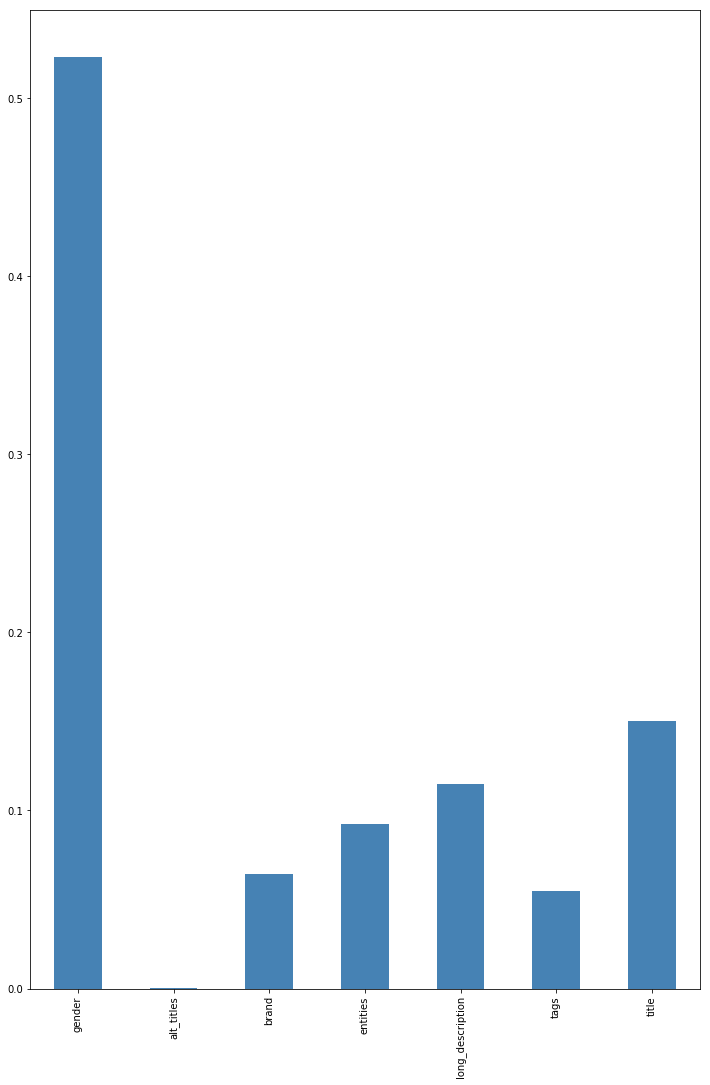

In [58]:
# plot a graph of feature importance and view thresholds
pltclf,X1,y1 = plot_feature_imp(df_train,target_col)

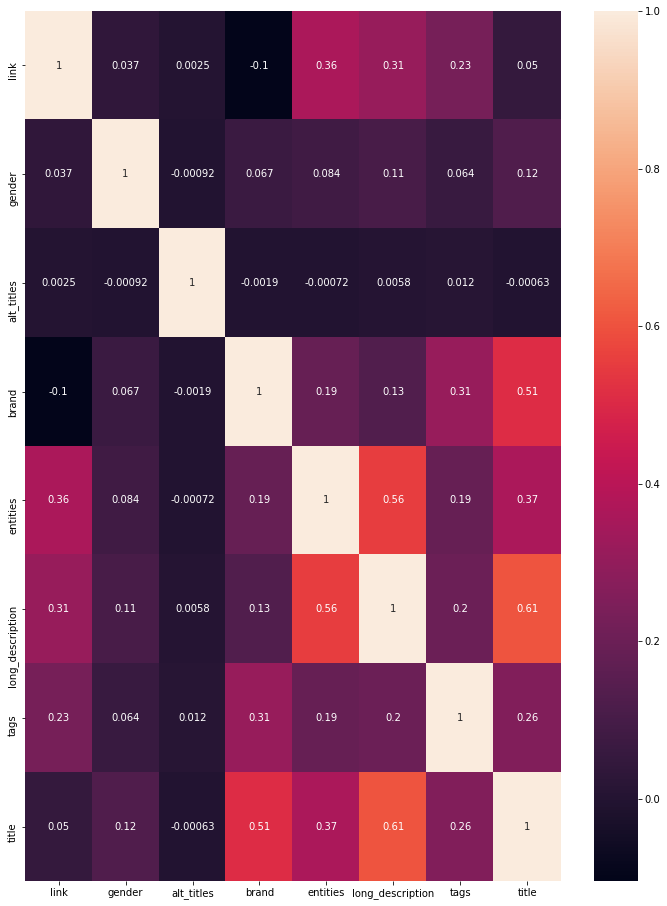

In [59]:
plot_corr(df_train)


 Check target class distribution 

col_0    count    percent
gender                   
0        41180  10.433875
1       353496  89.566125


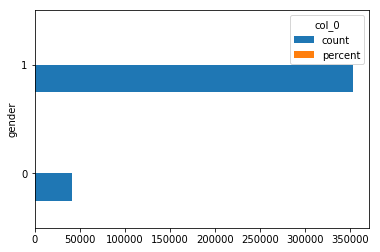

In [81]:
df_train.drop(['alt_titles','brand','entities'],1,inplace=True)
# view class distribution of target, this will affect sampling
class_dist(df_train,target_col)

In [61]:
df_train = reduce_dims(df_train,target_col)

C:\ProgramData\Anaconda3\lib\site-packages\deap\creator.py:141: RuntimeWarning: A class named 'FeatureSelect' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)
C:\ProgramData\Anaconda3\lib\site-packages\deap\creator.py:141: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


EVOLVING.......
-- GENERATION 1 --
Evaluated 56 weak individuals
-- GENERATION 2 --
Evaluated 54 weak individuals
-- GENERATION 3 --
Evaluated 59 weak individuals
-- GENERATION 4 --
Evaluated 60 weak individuals
-- GENERATION 5 --
Evaluated 53 weak individuals
-- Only the fittest survives --
Best individual is [1, 1, 0, 0, 1], (0.6874833199893247,)

 Columns retained after Genetic Selection Algorithm are: 
 ['link', 'entities', 'title']

 3 columns retained out of 5 



In [82]:
# class distribution is imbalanced , hence resampling is required
X,y,model_cols = create_Xy(df_train,target_col,imbalance = 'Y')


 No: of predictor variables is: 4 and no:of observations for training is: 706992 



> Stage 3: <b> Build and Train model for accuracy </b>

Train on 636292 samples, validate on 70700 samples
Epoch 1/10
636292/636292 [==============================] - 126s 198us/step - loss: 0.6687 - acc: 0.5907 - val_loss: 0.6596 - val_acc: 0.6011

Epoch 00001: val_acc improved from -inf to 0.60110, saving model to best_model.h5
Epoch 2/10
636292/636292 [==============================] - 46s 72us/step - loss: 0.6669 - acc: 0.5911 - val_loss: 0.6589 - val_acc: 0.6013

Epoch 00002: val_acc improved from 0.60110 to 0.60134, saving model to best_model.h5
Epoch 3/10
636292/636292 [==============================] - 44s 69us/step - loss: 0.6660 - acc: 0.5907 - val_loss: 0.6585 - val_acc: 0.6001

Epoch 00003: val_acc did not improve from 0.60134
Epoch 4/10
636292/636292 [==============================] - 42s 66us/step - loss: 0.6662 - acc: 0.5906 - val_loss: 0.6586 - val_acc: 0.6004

Epoch 00004: val_acc did not improve from 0.60134
Epoch 00004: early stopping
Train: 0.600, Test: 0.600


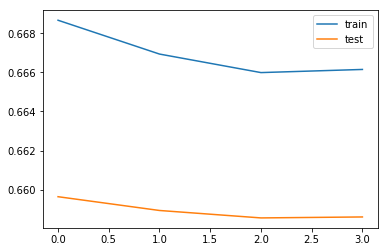


 Best F1 score for CV fold no:1 was:0.5712314248500121

Train on 636292 samples, validate on 70700 samples
Epoch 1/10
636292/636292 [==============================] - 43s 67us/step - loss: 0.6665 - acc: 0.5913 - val_loss: 0.6598 - val_acc: 0.5967

Epoch 00001: val_acc improved from -inf to 0.59669, saving model to best_model.h5
Epoch 2/10
636292/636292 [==============================] - 43s 67us/step - loss: 0.6659 - acc: 0.5908 - val_loss: 0.6584 - val_acc: 0.5991

Epoch 00002: val_acc improved from 0.59669 to 0.59909, saving model to best_model.h5
Epoch 3/10
636292/636292 [==============================] - 45s 70us/step - loss: 0.6659 - acc: 0.5903 - val_loss: 0.6588 - val_acc: 0.5991

Epoch 00003: val_acc did not improve from 0.59909
Epoch 00003: early stopping
Train: 0.600, Test: 0.599


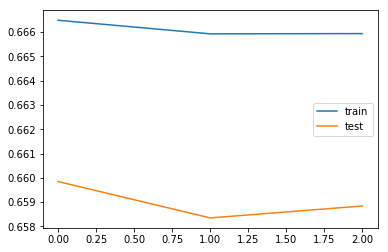


 Best F1 score for CV fold no:2 was:0.5696199831102413

Train on 636292 samples, validate on 70700 samples
Epoch 1/10
636292/636292 [==============================] - 45s 72us/step - loss: 0.6660 - acc: 0.5901 - val_loss: 0.6583 - val_acc: 0.6000

Epoch 00001: val_acc improved from -inf to 0.59999, saving model to best_model.h5
Epoch 2/10
636292/636292 [==============================] - 49s 77us/step - loss: 0.6656 - acc: 0.5899 - val_loss: 0.6584 - val_acc: 0.5996

Epoch 00002: val_acc did not improve from 0.59999
Epoch 00002: early stopping
Train: 0.600, Test: 0.600


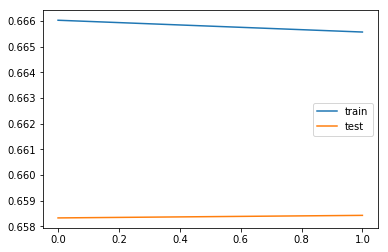


 Best F1 score for CV fold no:3 was:0.5701567380386918

Train on 636292 samples, validate on 70700 samples
Epoch 1/10
636292/636292 [==============================] - 45s 70us/step - loss: 0.6661 - acc: 0.5901 - val_loss: 0.6587 - val_acc: 0.5980

Epoch 00001: val_acc improved from -inf to 0.59803, saving model to best_model.h5
Epoch 2/10
636292/636292 [==============================] - 42s 65us/step - loss: 0.6659 - acc: 0.5902 - val_loss: 0.6576 - val_acc: 0.6002

Epoch 00002: val_acc improved from 0.59803 to 0.60017, saving model to best_model.h5
Epoch 3/10
636292/636292 [==============================] - 41s 65us/step - loss: 0.6660 - acc: 0.5897 - val_loss: 0.6589 - val_acc: 0.6001

Epoch 00003: val_acc did not improve from 0.60017
Epoch 00003: early stopping
Train: 0.599, Test: 0.600


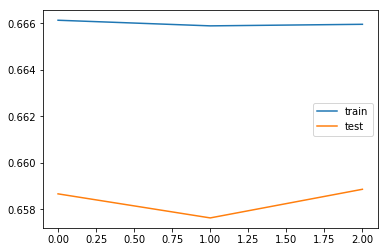


 Best F1 score for CV fold no:4 was:0.5711582090531219

Train on 636292 samples, validate on 70700 samples
Epoch 1/10
636292/636292 [==============================] - 47s 73us/step - loss: 0.6660 - acc: 0.5899 - val_loss: 0.6571 - val_acc: 0.6023

Epoch 00001: val_acc improved from -inf to 0.60229, saving model to best_model.h5
Epoch 2/10
636292/636292 [==============================] - 43s 67us/step - loss: 0.6660 - acc: 0.5900 - val_loss: 0.6576 - val_acc: 0.6011

Epoch 00002: val_acc did not improve from 0.60229
Epoch 00002: early stopping
Train: 0.600, Test: 0.601


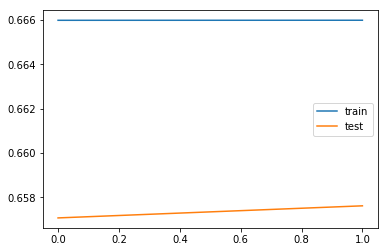


 Best F1 score for CV fold no:5 was:0.5725959089493943

Train on 636292 samples, validate on 70700 samples
Epoch 1/10
636292/636292 [==============================] - 44s 70us/step - loss: 0.6659 - acc: 0.5899 - val_loss: 0.6586 - val_acc: 0.5971

Epoch 00001: val_acc improved from -inf to 0.59707, saving model to best_model.h5
Epoch 2/10
636292/636292 [==============================] - 43s 68us/step - loss: 0.6659 - acc: 0.5899 - val_loss: 0.6577 - val_acc: 0.6010

Epoch 00002: val_acc improved from 0.59707 to 0.60102, saving model to best_model.h5
Epoch 3/10
636292/636292 [==============================] - 42s 65us/step - loss: 0.6660 - acc: 0.5900 - val_loss: 0.6576 - val_acc: 0.6021

Epoch 00003: val_acc improved from 0.60102 to 0.60205, saving model to best_model.h5
Epoch 4/10
636292/636292 [==============================] - 44s 69us/step - loss: 0.6658 - acc: 0.5903 - val_loss: 0.6573 - val_acc: 0.6022

Epoch 00004: val_acc improved from 0.60205 to 0.60222, saving model to best_

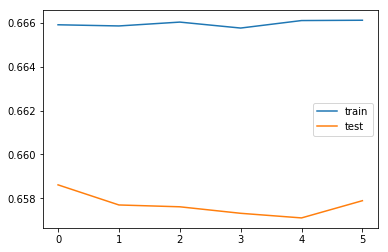


 Best F1 score for CV fold no:6 was:0.5766234421602597

Train on 636294 samples, validate on 70698 samples
Epoch 1/10
636294/636294 [==============================] - 49s 77us/step - loss: 0.6659 - acc: 0.5900 - val_loss: 0.6571 - val_acc: 0.6032

Epoch 00001: val_acc improved from -inf to 0.60320, saving model to best_model.h5
Epoch 2/10
636294/636294 [==============================] - 43s 68us/step - loss: 0.6663 - acc: 0.5894 - val_loss: 0.6583 - val_acc: 0.5984

Epoch 00002: val_acc did not improve from 0.60320
Epoch 00002: early stopping
Train: 0.597, Test: 0.598


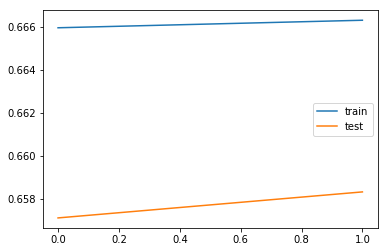


 Best F1 score for CV fold no:7 was:0.5663123146021577

Train on 636294 samples, validate on 70698 samples
Epoch 1/10
636294/636294 [==============================] - 47s 73us/step - loss: 0.6656 - acc: 0.5900 - val_loss: 0.6589 - val_acc: 0.5996

Epoch 00001: val_acc improved from -inf to 0.59958, saving model to best_model.h5
Epoch 2/10
636294/636294 [==============================] - 48s 75us/step - loss: 0.6659 - acc: 0.5896 - val_loss: 0.6583 - val_acc: 0.6020

Epoch 00002: val_acc improved from 0.59958 to 0.60200, saving model to best_model.h5
Epoch 3/10
636294/636294 [==============================] - 49s 76us/step - loss: 0.6658 - acc: 0.5899 - val_loss: 0.6591 - val_acc: 0.5953

Epoch 00003: val_acc did not improve from 0.60200
Epoch 00003: early stopping
Train: 0.595, Test: 0.595


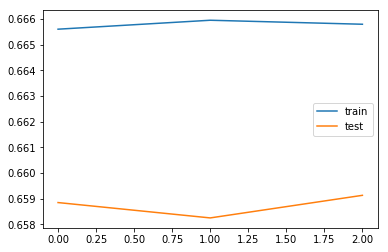


 Best F1 score for CV fold no:8 was:0.5622247585536473

Train on 636294 samples, validate on 70698 samples
Epoch 1/10
636294/636294 [==============================] - 46s 73us/step - loss: 0.6662 - acc: 0.5897 - val_loss: 0.6581 - val_acc: 0.5990

Epoch 00001: val_acc improved from -inf to 0.59898, saving model to best_model.h5
Epoch 2/10
636294/636294 [==============================] - 43s 67us/step - loss: 0.6660 - acc: 0.5900 - val_loss: 0.6578 - val_acc: 0.6008

Epoch 00002: val_acc improved from 0.59898 to 0.60078, saving model to best_model.h5
Epoch 3/10
636294/636294 [==============================] - 45s 71us/step - loss: 0.6661 - acc: 0.5903 - val_loss: 0.6586 - val_acc: 0.5979

Epoch 00003: val_acc did not improve from 0.60078
Epoch 00003: early stopping
Train: 0.600, Test: 0.598


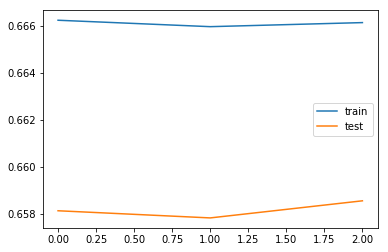


 Best F1 score for CV fold no:9 was:0.5692716859976159

Train on 636294 samples, validate on 70698 samples
Epoch 1/10
636294/636294 [==============================] - 46s 72us/step - loss: 0.6661 - acc: 0.5896 - val_loss: 0.6575 - val_acc: 0.6002

Epoch 00001: val_acc improved from -inf to 0.60016, saving model to best_model.h5
Epoch 2/10
636294/636294 [==============================] - 45s 70us/step - loss: 0.6662 - acc: 0.5900 - val_loss: 0.6573 - val_acc: 0.5986

Epoch 00002: val_acc did not improve from 0.60016
Epoch 3/10
636294/636294 [==============================] - 42s 67us/step - loss: 0.6660 - acc: 0.5900 - val_loss: 0.6579 - val_acc: 0.6012

Epoch 00003: val_acc improved from 0.60016 to 0.60118, saving model to best_model.h5
Epoch 00003: early stopping
Train: 0.602, Test: 0.601


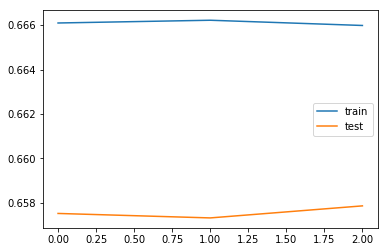


 Best F1 score for CV fold no:10 was:0.5751831571693857


 Best Model has the following scores :

Train: 0.602, Test: 0.601

Final F1 score:  0.57 
- - - - -  

Elapsed Training Time approx :31.098886277333317 minutes


In [83]:
# Initialize and train a Neural network Classfier model
neural_network = creatNN(len(model_cols),X.shape[0])

# store it as the best model till now
best_clfname = 'neural_network'

# Create classifier, train it and test it.
start_time = timeit.default_timer()   
       
# calculate accuracy 
bestF1,best_clf = F1_score(neural_network,X,y,nn='Y')
print ("\nFinal F1 score: ", round(bestF1, 3), "\n- - - - - ", "\n")
print('Elapsed Training Time approx :{} minutes'.format((timeit.default_timer() - start_time)/60))

> Stage 4: <b> use Best Model to predict segment on Test Data </b>

In [84]:
# Load the Testing data file with UserId and Actual Gender information
filename = 'UserId_Test.csv'
predictor = 'userid'

df_userId_Test = pd.read_csv(filename)
df_userId_Test = dedup_data(df_userId_Test)
df_userId_Test.shape

(88384, 1)

##### Prepare the Test File by taking information from previously loaded files

In [85]:
#1. First, merge gender UserID to UserID to URL data using UserId as the key(Index)

df_test = df_userId_Test.set_index('userid')

# perform left outer join to retain all data in the training(UserID, Gender) file
df_test = df_test.merge(df_userId_url, on='userid',how='outer')

df_test.reset_index(inplace=True)

df_test = dedup_data(df_test) # dedupe again after the join

#2. Next, merge UserID gender and URL file to URL data using url and link as keys(Index)

df_test.set_index('url',inplace=True) # set index to key column for merge

# perform left outer join to retain all data in the training(UserID, Gender) file
df_test = df_test.merge(df_urls_data, right_on='link',left_index=True,how='outer')

df_test.reset_index(inplace=True)

df_test = dedup_data(df_test,keylist=['userid']) # final dedupe again after all joins

In [86]:
df_test.userid.nunique()

317828

#### Preprocess test data exactly as done for training

In [87]:
df_test = prep_Data(df_test)
df_test = imputeNulls(df_test)
df_test = encode_cols(df_test)


scaler = MinMaxScaler()
df_test = scale_cols(df_test,scaler,[predictor,target_col])


 Basic Metadata 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 317829 entries, 0 to 317828
Data columns (total 8 columns):
link                317829 non-null object
userid              317828 non-null float64
alt_titles          179653 non-null object
brand               179604 non-null object
entities            179653 non-null object
long_description    64549 non-null object
tags                179653 non-null object
title               179653 non-null object
dtypes: float64(1), object(7)
memory usage: 21.8+ MB
None

 Missing values information 

                       column_name  percent_missing
long_description  long_description        79.690651
brand                        brand        43.490367
alt_titles              alt_titles        43.474950
entities                  entities        43.474950
tags                          tags        43.474950
title                        title        43.474950
userid                      userid         0.000315

 List of columns with

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:334: DataConversionWarning: Data with input dtype int32 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


In [88]:
df_test.userid.nunique()

317829

In [89]:
# predict classes and store in a column called 'gender'
df_test[target_col]= best_clf.predict(df_test[model_cols])

df_test[target_col] = df_test[target_col].apply(lambda x:'F' if x==0 else 'M')
#write the output file to disk
outfilename = 'application_test_predict.csv'
df_test[[predictor,target_col]].to_csv(outfilename,index=False)